In [1]:
#Libraries to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import string

In [2]:
# Read in data
df = pd.read_csv('At risk customers data.csv')
df = df.dropna(subset=['Reviews'])
df.head()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,...,Region,ByCash,Color,ProductOnSale,ProductSeason,Reviews,Salary,Score,date,TotalCost
0,1001,2023-05-26,181,1,944.0,272.0,233.0,449.0,40.0,34.0,...,South America,1,Purple,0.0,spring,Adidas compression shorts provide excellent su...,569,4,2023-05-26,944.00
1,1005,2023-11-03,20,1,662.0,628.0,233.0,309.0,91.0,34.0,...,North America,1,Yellow,0.0,summer,The quality of Adidas shoes could be better fo...,1119,2,2023-11-03,662.00
2,1006,2023-05-03,204,1,954.0,229.0,233.0,466.0,33.0,34.0,...,Asia,0,Brown,0.0,summer,Adidas basketball shorts for kids combine styl...,548,5,2023-05-03,953.75
3,1007,2023-08-05,110,1,206.0,413.0,233.0,94.0,60.0,34.0,...,Asia,1,Red,0.0,spring,Adidas golf visors offer sun protection with a...,593,5,2023-08-05,206.00
4,1009,2023-09-13,71,1,247.0,499.0,233.0,110.0,73.0,34.0,...,Asia,1,mix,0.0,summer,Adidas needs to keep up with the latest fashio...,419,2,2023-09-13,247.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        451 non-null    int64  
 1   LastPurshaceDate  451 non-null    object 
 2   Recency           451 non-null    int64  
 3   Frequency         451 non-null    int64  
 4   Monetary          451 non-null    float64
 5   R_rank            451 non-null    float64
 6   F_rank            451 non-null    float64
 7   M_rank            451 non-null    float64
 8   R_rank_norm       451 non-null    float64
 9   F_rank_norm       451 non-null    float64
 10  M_rank_norm       451 non-null    float64
 11  RFM_Score         451 non-null    float64
 12  Customer_segment  451 non-null    object 
 13  TransactionID     451 non-null    int64  
 14  PurchaseDate      451 non-null    object 
 15  Quantity          451 non-null    float64
 16  Unit price        451 non-null    float64
 1

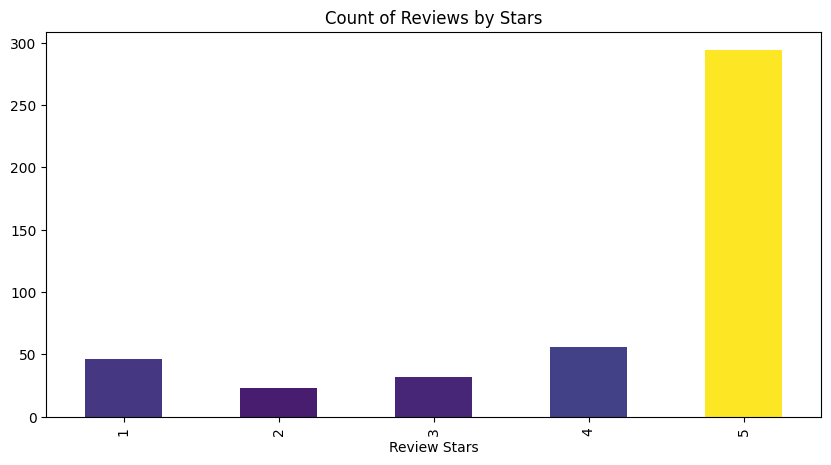

In [4]:
scores_counts = df['Score'].value_counts().sort_index()

# Use the 'viridis' colormap directly based on the values
colors = plt.cm.viridis(scores_counts.values / scores_counts.values.max())

ax = scores_counts.plot(kind='bar',
                        title='Count of Reviews by Stars',
                        figsize=(10, 5),
                        color=colors)

ax.set_xlabel('Review Stars')
plt.show()

In [5]:
# Download NLTK resources (run this once if you haven't already)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


# Words to remove in addition to stop words
additional_stop_words = ['br', 'adidas', 'allowing', 'provide', 'offer', 'may']

# Tokenize and remove stop words and specified words for each row in the "Text" column
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in (stop_words | set(additional_stop_words)) and word.isalpha()]
    return ' '.join(filtered_words)

df['processed_text'] = df['Reviews'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
df[['Reviews', 'processed_text']]

,Reviews,processed_text
0,Adidas compression shorts provide excellent su...,compression shorts excellent support without c...
1,The quality of Adidas shoes could be better fo...,quality shoes could better price
2,Adidas basketball shorts for kids combine styl...,basketball shorts kids combine style functiona...
3,Adidas golf visors offer sun protection with a...,golf visors sun protection sporty look enhanci...
4,Adidas needs to keep up with the latest fashio...,needs keep latest fashion trends
...,...,...
446,Adidas volleyball shoes for kids provide comfo...,volleyball shoes kids comfort support enhancin...
447,Adidas soccer balls provide consistent perform...,soccer balls consistent performance making sui...
448,Adidas skate shoes provide excellent grip and ...,skate shoes excellent grip durability skateboa...
449,Adidas lacks the premium feel I expect from a ...,lacks premium feel expect brand


In [7]:
sia = SentimentIntensityAnalyzer()

In [8]:
from tqdm import tqdm

# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['processed_text']
    myid = row['CustomerID']
    res[myid] = sia.polarity_scores(text)

100%|██████████████████████████████████████████████████████████████████████████████| 451/451 [00:00<00:00, 3662.45it/s]


In [9]:
vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
1001,0.169,0.320,0.512,0.6474
1005,0.000,0.580,0.420,0.4404
1006,0.000,1.000,0.000,0.0000
1007,0.000,1.000,0.000,0.0000
1009,0.000,1.000,0.000,0.0000
...,...,...,...,...
2289,0.000,0.536,0.464,0.6369
2292,0.000,1.000,0.000,0.0000
2295,0.000,0.450,0.550,0.7269
2299,0.000,1.000,0.000,0.0000


In [10]:
vaders = vaders.reset_index().rename(columns={'index': 'CustomerID'})
vaders = df.merge(vaders, how='left')

In [11]:
# Now we have sentiment score and our adata
vaders.head()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,...,Reviews,Salary,Score,date,TotalCost,processed_text,neg,neu,pos,compound
0,1001,2023-05-26,181,1,944.0,272.0,233.0,449.0,40.0,34.0,...,Adidas compression shorts provide excellent su...,569,4,2023-05-26,944.00,compression shorts excellent support without c...,0.169,0.32,0.512,0.6474
1,1005,2023-11-03,20,1,662.0,628.0,233.0,309.0,91.0,34.0,...,The quality of Adidas shoes could be better fo...,1119,2,2023-11-03,662.00,quality shoes could better price,0.000,0.58,0.420,0.4404
2,1006,2023-05-03,204,1,954.0,229.0,233.0,466.0,33.0,34.0,...,Adidas basketball shorts for kids combine styl...,548,5,2023-05-03,953.75,basketball shorts kids combine style functiona...,0.000,1.00,0.000,0.0000
3,1007,2023-08-05,110,1,206.0,413.0,233.0,94.0,60.0,34.0,...,Adidas golf visors offer sun protection with a...,593,5,2023-08-05,206.00,golf visors sun protection sporty look enhanci...,0.000,1.00,0.000,0.0000
4,1009,2023-09-13,71,1,247.0,499.0,233.0,110.0,73.0,34.0,...,Adidas needs to keep up with the latest fashio...,419,2,2023-09-13,247.00,needs keep latest fashion trends,0.000,1.00,0.000,0.0000


In [12]:
vaders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        451 non-null    int64  
 1   LastPurshaceDate  451 non-null    object 
 2   Recency           451 non-null    int64  
 3   Frequency         451 non-null    int64  
 4   Monetary          451 non-null    float64
 5   R_rank            451 non-null    float64
 6   F_rank            451 non-null    float64
 7   M_rank            451 non-null    float64
 8   R_rank_norm       451 non-null    float64
 9   F_rank_norm       451 non-null    float64
 10  M_rank_norm       451 non-null    float64
 11  RFM_Score         451 non-null    float64
 12  Customer_segment  451 non-null    object 
 13  TransactionID     451 non-null    int64  
 14  PurchaseDate      451 non-null    object 
 15  Quantity          451 non-null    float64
 16  Unit price        451 non-null    float64
 1

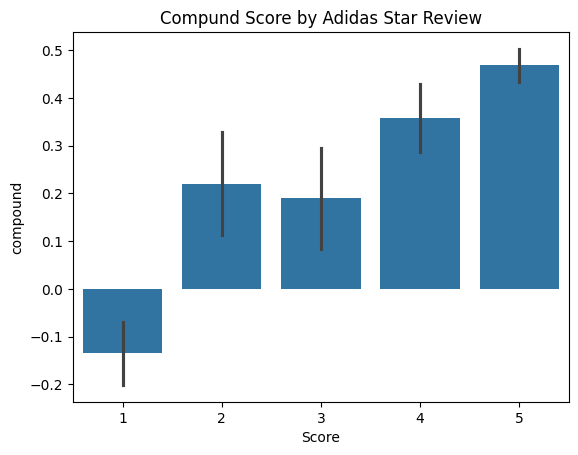

In [13]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Adidas Star Review')

plt.savefig('compound.png')

plt.show()

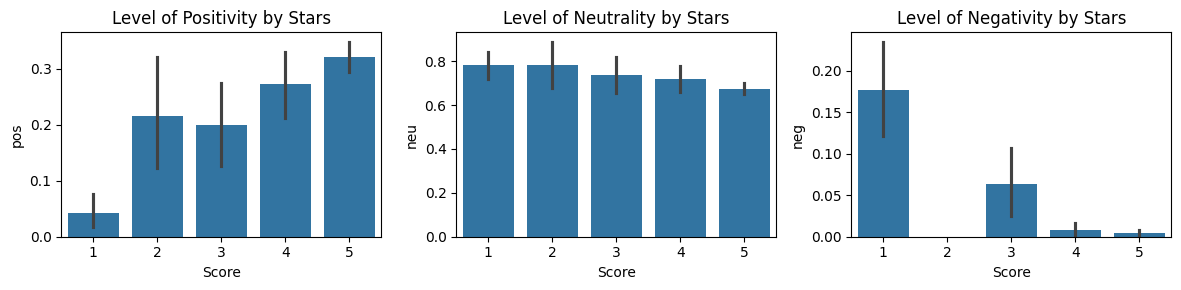

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Level of Positivity by Stars')
axs[1].set_title('Level of Neutrality by Stars')
axs[2].set_title('Level of Negativity by Stars')
plt.tight_layout()

plt.savefig('sentiment lvl.png')

plt.show()

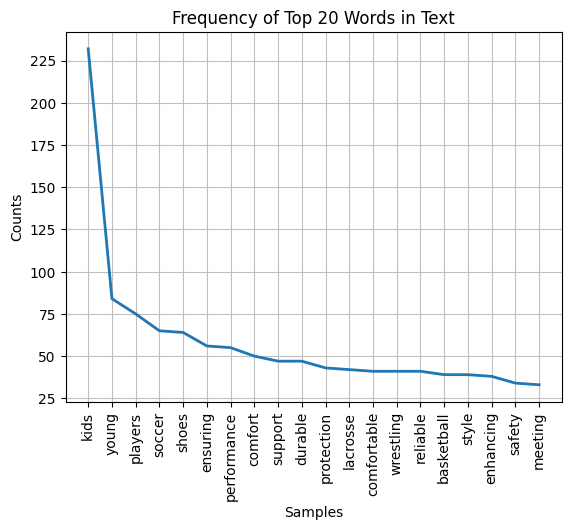

In [15]:
#from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


# Instantiate a frequency dictionary
fdist = FreqDist()

# Iterate through each row in the 'text' column of the DataFrame
for index, row in vaders.iterrows():
    text = row['processed_text']
    # Tokenize and count frequencies of words in each text
    for word in word_tokenize(text):
        fdist[word.lower()] += 1

# Plot the distribution of frequencies for the top 20 words
fdist.plot(20, title='Frequency of Top 20 Words in Text')
plt.show()

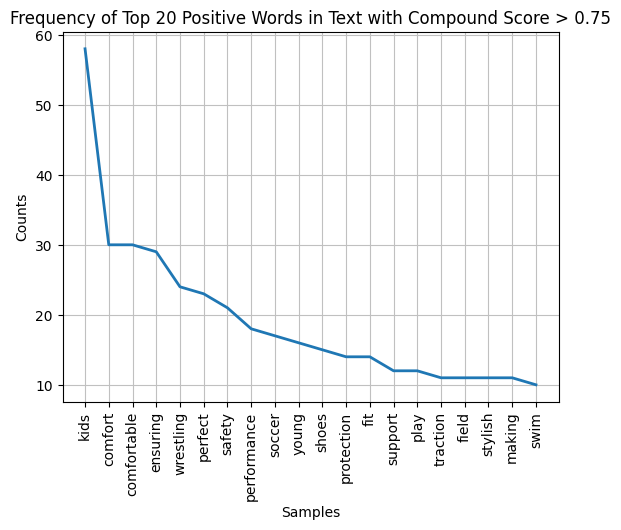

In [16]:
# Instantiate a Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Instantiate a frequency dictionary
fdist = FreqDist()

# Iterate through each row in the DataFrame
for index, row in vaders.iterrows():
    text = row['processed_text']
    # Calculate the compound sentiment score for each text
    compound_score = sid.polarity_scores(text)['compound']
    
    # Check if the compound score is higher than 0.75
    if compound_score > 0.75:
        # Tokenize and count frequencies of words in each text
        for word in word_tokenize(text):
            fdist[word.lower()] += 1

# Plot the distribution of frequencies for the top 20 words
fdist.plot(20, title='Frequency of Top 20 Positive Words in Text with Compound Score > 0.75')
plt.show()

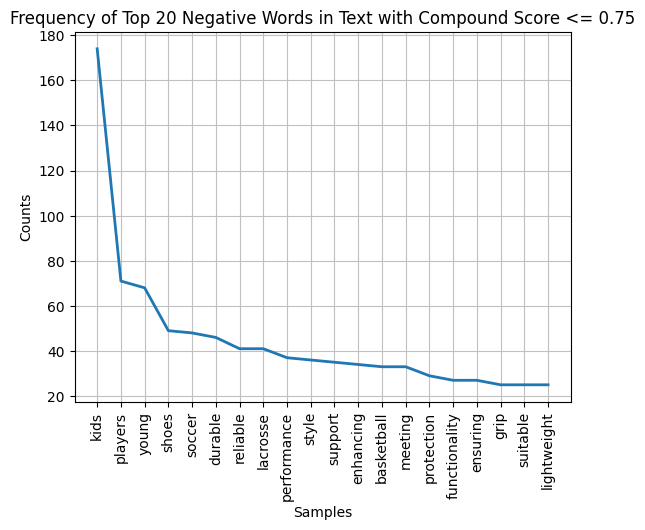

In [17]:
# Instantiate a Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Instantiate a frequency dictionary
fdist = FreqDist()

# Iterate through each row in the DataFrame
for index, row in vaders.iterrows():
    text = row['processed_text']
    # Calculate the compound sentiment score for each text
    compound_score = sid.polarity_scores(text)['compound']
    
    # Check if the compound score is higher than 0.75
    if compound_score <= 0.75:
        # Tokenize and count frequencies of words in each text
        for word in word_tokenize(text):
            fdist[word.lower()] += 1

# Plot the distribution of frequencies for the top 20 words
fdist.plot(20, title='Frequency of Top 20 Negative Words in Text with Compound Score <= 0.75')
plt.show()

# KPI 2 CSAT: Customer Satisfaction Rate

In [18]:
satisfied_responses = df[df['Score'].isin([4, 5])].shape[0]

total_responses = df.shape[0]

percentage_satisfied = (satisfied_responses / total_responses) * 100

print(f"Total number of satisfied responses: {satisfied_responses}")
print(f"Total number of responses: {total_responses}")
print(f"Percentage of satisfied responses: {percentage_satisfied:.2f}%")

Total number of satisfied responses: 350
Total number of responses: 451
Percentage of satisfied responses: 77.61%
